# Screen of Growth Indicators

In [64]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import os

%matplotlib inline

In [65]:
from dotenv import load_dotenv
load_dotenv()
FRED_KEY = os.getenv("FRED_KEY")

In [66]:
from urllib.request import urlopen
import json

def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

## Data Cleaning

In [67]:
# Pulling time series:
def pull_time_series(time_series_code, dataframe_name):

    url = (f"https://api.stlouisfed.org/fred/series/observations?series_id={time_series_code}&api_key={FRED_KEY}&file_type=json")
    raw_data = get_jsonparsed_data(url)
    dataframe_name = pd.DataFrame(raw_data['observations'])
    
    # convert to datetime
    dataframe_name['Date'] = pd.to_datetime(dataframe_name['date'])
    dataframe_name.set_index('Date', inplace=True)
    dataframe_name = dataframe_name.drop(columns=["date", "realtime_start", "realtime_end"]).sort_index()
    dataframe_name['value'] = pd.to_numeric(dataframe_name['value'],errors='coerce')
    return dataframe_name

In [68]:
# Pull Raw data for model
US_GDP_data = pull_time_series("A191RL1Q225SBEA", "US_GDP_Growth")

US_GDP_df = pull_time_series("GDPC1", "REAL_GDP")
US_Real_PCE_data = pull_time_series("PCEC96", "US_Real_PCE")
US_Initial_Claims_data = pull_time_series("ICSA", "US_Initial_Claims")
US_Cap_Util = pull_time_series("TCU", "US_Capital_Utilization")

US_Real_Disposable_Income = pull_time_series("DSPIC96", "Real_Disposable_Personal_Income")
US_Personal_Savings_Rate = pull_time_series("PSAVERT", "US_Personal_Savings_Rate_%_of_DPI")
US_M2_stock = pull_time_series("M2", "M2_Money_Stock")

In [69]:
# Setting up universal data cleaning functions for FRED data
def clean_data(df,variable_name):
    df.rename(columns={"value":variable_name},inplace=True)
    return df

# def set_date(df):
#     df = df.reset_index()
#     df["Date"] = df["Date"] - pd.Timedelta(1, unit='d')
#     df.set_index(df["Date"], inplace=True)
#     df = df.drop(columns=["Date"])
#     return df

def set_date_to_month_end(df):
    df.index = df.index.to_period('M').to_timestamp('M')
    return df

### GDP Processing Section

In [70]:
# Change Column Name
clean_data(US_GDP_df, "Real GDP")

# Adding a YoY column
US_GDP_df["Real GDP YoY"] = US_GDP_df['Real GDP'].pct_change(4)*100
US_GDP_df["Real GDP"] = US_GDP_df["Real GDP"].replace(-np.inf, np.nan).dropna()


# Resetting Date Index to last day of each quarter
US_GDP_df = US_GDP_df.reset_index()
US_GDP_df["Date"] = US_GDP_df["Date"] - pd.Timedelta(1, unit='d')
US_GDP_df.set_index(US_GDP_df["Date"], inplace=True)
US_GDP_df = US_GDP_df.drop(columns=["Date"])


US_GDP_df.tail()

,Real GDP,Real GDP YoY
Date,,
2019-03-31,19020.599,1.963163
2019-06-30,19141.744,2.076481
2019-09-30,19253.959,2.338885
2019-12-31,19010.848,0.319261
2020-03-31,17282.188,-9.139623


### Macro Indicators Processing Section

In [71]:
# Clean PCE data
clean_data(US_Real_PCE_data, "Real_PCE")
US_Real_PCE_data["Real_PCE_YoY"] = US_Real_PCE_data['Real_PCE'].pct_change(12)*100
US_Real_PCE_data["Real_PCE_YoY"] = US_Real_PCE_data["Real_PCE_YoY"].replace(-np.inf, np.nan).dropna()

# Changing date index to last day of the month
US_Real_PCE_data = set_date_to_month_end(US_Real_PCE_data)

US_Real_PCE_data.tail()

,Real_PCE,Real_PCE_YoY
Date,,
2020-03-31,12536.1,-4.694532
2020-04-30,10977.0,-16.698919
2020-05-31,11904.1,-9.882964
2020-06-30,12577.6,-5.084029
2020-07-31,12778.2,-3.771368


In [72]:
# Clean US Initial Claims data
clean_data(US_Initial_Claims_data, "Initial_Claims")

# Resample Weekly data to Monthly
US_Initial_Claims_data_resampled = US_Initial_Claims_data.Initial_Claims.resample('M').sum()
US_Initial_Claims_data_resampled = pd.DataFrame(US_Initial_Claims_data_resampled)

# Calculate YoY change
US_Initial_Claims_data_resampled["Initial_Claims_YoY"] = US_Initial_Claims_data_resampled['Initial_Claims'].pct_change(12)*100
US_Initial_Claims_data_resampled["Initial_Claims_YoY"] = US_Initial_Claims_data_resampled["Initial_Claims_YoY"].replace(-np.inf, np.nan).dropna()
US_Initial_Claims_data_resampled.tail()


,Initial_Claims,Initial_Claims_YoY
Date,,
2020-05-31,12329000,1312.256586
2020-06-30,5996000,442.624434
2020-07-31,5475000,540.350877
2020-08-31,5161000,377.428307
2020-09-30,884000,3.755869


In [73]:
# Clean capacity utilization data
clean_data(US_Cap_Util, "Capacity_Utilization")
US_Cap_Util["Cap_Util_YoY_Change"] = US_Cap_Util['Capacity_Utilization'].pct_change(12)*100
US_Cap_Util["Cap_Util_YoY_Change"] = US_Cap_Util["Cap_Util_YoY_Change"].replace(-np.inf, np.nan).dropna()

# Changing date index to last day of the month
US_Cap_Util = set_date_to_month_end(US_Cap_Util)

US_Cap_Util.tail()

,Capacity_Utilization,Cap_Util_YoY_Change
Date,,
2020-03-31,73.6134,-6.103680
2020-04-30,64.1954,-17.448752
2020-05-31,64.7785,-16.732223
2020-06-30,68.4643,-11.880347
2020-07-31,70.5584,-8.867535


In [74]:
# Clean US_Personal_Savings_Rate data

clean_data(US_Personal_Savings_Rate, "US_Personal_Savings_Rate_%_of_DPI")
US_Personal_Savings_Rate["US_Personal_Savings_Rate_%_of_DPI_YoY"] = US_Personal_Savings_Rate['US_Personal_Savings_Rate_%_of_DPI'].pct_change(12)*100
US_Personal_Savings_Rate["US_Personal_Savings_Rate_%_of_DPI_YoY"] = US_Personal_Savings_Rate["US_Personal_Savings_Rate_%_of_DPI_YoY"].replace(-np.inf, np.nan).dropna()

# Changing date index to last day of the month
US_Personal_Savings_Rate = set_date_to_month_end(US_Personal_Savings_Rate)

US_Personal_Savings_Rate.tail()

,US_Personal_Savings_Rate_%_of_DPI,US_Personal_Savings_Rate_%_of_DPI_YoY
Date,,
2020-03-31,12.9,61.250000
2020-04-30,33.7,349.333333
2020-05-31,24.6,236.986301
2020-06-30,19.2,170.422535
2020-07-31,17.8,154.285714


In [75]:
US_Personal_Savings_Rate.tail()

,US_Personal_Savings_Rate_%_of_DPI,US_Personal_Savings_Rate_%_of_DPI_YoY
Date,,
2020-03-31,12.9,61.250000
2020-04-30,33.7,349.333333
2020-05-31,24.6,236.986301
2020-06-30,19.2,170.422535
2020-07-31,17.8,154.285714


In [76]:
# Clean US_Real_Disposable_Income data

clean_data(US_Real_Disposable_Income, "US_Real_DPI")
US_Real_Disposable_Income["Real_DPI_YoY"] = US_Real_Disposable_Income['US_Real_DPI'].pct_change(12)*100
US_Real_Disposable_Income["Real_DPI_YoY"] = US_Real_Disposable_Income["Real_DPI_YoY"].replace(-np.inf, np.nan).dropna()

# Changing date index to last day of the month
US_Real_Disposable_Income = set_date_to_month_end(US_Real_Disposable_Income)

US_Real_Disposable_Income.tail()

,US_Real_DPI,Real_DPI_YoY
Date,,
2020-03-31,14949.3,0.630061
2020-04-30,17254.7,16.450476
2020-05-31,16400.8,10.744382
2020-06-30,16107.2,8.635714
2020-07-31,16091.6,8.431770


In [77]:
# Clean M2 Money stock data
clean_data(US_M2_stock, "M2")
M2_stock_resampled = US_M2_stock.resample('M').last()

# Calculate Monthly percentage change
M2_stock_resampled["M2_Money_Supply_YoY"] = M2_stock_resampled['M2'].pct_change(12)*100
M2_stock_resampled["M2_Money_Supply_YoY"] = M2_stock_resampled["M2_Money_Supply_YoY"].replace(-np.inf, np.nan).dropna()
M2_stock_resampled.tail(13)

,M2,M2_Money_Supply_YoY
Date,,
2019-08-31,14938.2,4.993780
2019-09-30,15086.4,5.975077
2019-10-31,15189.1,6.605138
2019-11-30,15282.4,7.193760
2019-12-31,15333.6,6.388027
2020-01-31,15445.3,6.724663
2020-02-29,15434.1,6.653169
2020-03-31,16533.3,13.860213
2020-04-30,17406.4,19.312628


### Final Summary Section

Here I concat all the separate factor dataframes and transpose to show the last years worth of values. The summary dataframes are then broken out between raw values and Year-over-Year values. These dataframes are then exported to excel for display purposes.

In [78]:
# Concat dataframes
master_df = pd.concat([US_Real_PCE_data,
                       US_Initial_Claims_data_resampled, 
                       US_Cap_Util,
                       US_Real_Disposable_Income,
                       US_Personal_Savings_Rate, 
                       M2_stock_resampled], axis="columns", join='outer')

master_df = master_df.iloc[-50:,:]


In [79]:
# Transpose Dataframe

master_df_transposed = master_df.transpose()
master_df_transposed = master_df_transposed.round(decimals=2)
master_df_transposed = master_df_transposed.iloc[:,-13:]
master_df_transposed_copy = master_df_transposed.copy()

In [93]:
# Rate of Change Summary

master_YoY_df = master_df.drop(columns=["Real_PCE","Initial_Claims", "Capacity_Utilization", "US_Real_DPI", "US_Personal_Savings_Rate_%_of_DPI","M2"])
master_YoY_df_transposed = master_YoY_df.transpose()

master_YoY_df_transposed = master_YoY_df_transposed.round(decimals=2)
master_YoY_df_transposed = master_YoY_df_transposed.iloc[:,-13:]
master_YoY_df_transposed_copy = master_YoY_df_transposed.copy()
master_YoY_df_transposed_copy

Date,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30
Real_PCE_YoY,2.58,2.30,2.06,3.02,2.69,2.61,-4.69,-16.70,-9.88,-5.08,-3.77,NaN,NaN
Initial_Claims_YoY,-19.85,-0.23,20.81,-17.67,-3.41,17.44,879.52,2238.86,1312.26,442.62,540.35,377.43,3.76
Cap_Util_YoY_Change,-2.30,-2.90,-2.51,-2.89,-2.70,-1.95,-6.10,-17.45,-16.73,-11.88,-8.87,NaN,NaN
Real_DPI_YoY,2.02,1.81,2.10,0.83,1.55,2.01,0.63,16.45,10.74,8.64,8.43,NaN,NaN
US_Personal_Savings_Rate_%_of_DPI_YoY,-7.59,-5.26,1.35,-20.88,-10.59,-3.49,61.25,349.33,236.99,170.42,154.29,NaN,NaN
M2_Money_Supply_YoY,5.98,6.61,7.19,6.39,6.72,6.65,13.86,19.31,22.06,23.21,22.68,23.61,NaN


In [104]:
# Factor Summary

master_factor_df = master_df.drop(columns=["Real_PCE_YoY",
                                        "Initial_Claims_YoY", 
                                        "Cap_Util_YoY_Change", 
                                        "Real_DPI_YoY", 
                                        "US_Personal_Savings_Rate_%_of_DPI_YoY",
                                        "M2_Money_Supply_YoY"])

master_factor_df_transposed = master_factor_df.transpose()

master_factor_df_transposed = master_factor_df_transposed.round(decimals=2)
master_factor_df_transposed = master_factor_df_transposed.iloc[:,-13:]
master_factor_df_transposed

Date,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30
Real_PCE,13319.50,13344.30,13356.20,13360.60,13416.70,13402.40,12536.10,10977.0,11904.10,12577.60,12778.20,NaN,NaN
Initial_Claims,852000.00,860000.00,1074000.00,904000.00,851000.00,1057000.00,10667000.00,20161000.0,12329000.00,5996000.00,5475000.00,5161000.0,884000.0
Capacity_Utilization,77.43,76.99,77.57,77.17,76.88,76.93,73.61,64.2,64.78,68.46,70.56,NaN,NaN
US_Real_DPI,14933.60,14936.20,14997.20,14960.20,15070.20,15162.60,14949.30,17254.7,16400.80,16107.20,16091.60,NaN,NaN
US_Personal_Savings_Rate_%_of_DPI,7.30,7.20,7.50,7.20,7.60,8.30,12.90,33.7,24.60,19.20,17.80,NaN,NaN
M2,15086.40,15189.10,15282.40,15333.60,15445.30,15434.10,16533.30,17406.4,17938.50,18233.40,18284.40,18464.4,NaN


In [105]:
# Export to XLSX
import xlsxwriter
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('US_Macro_Screen.xlsx', engine='xlsxwriter', date_format='yyyy mm dd', datetime_format='yyyy mm dd')

# Convert the dataframe to an XlsxWriter Excel object.
master_df_transposed.to_excel(writer, sheet_name='US_Macro_Screen', float_format='%.2f')
master_YoY_df_transposed.to_excel(writer, sheet_name='US_Factors_YoY', float_format='%.2f')
master_factor_df_transposed.to_excel(writer, sheet_name='US_Raw_Factors', float_format='%.2f')
# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Charting Section

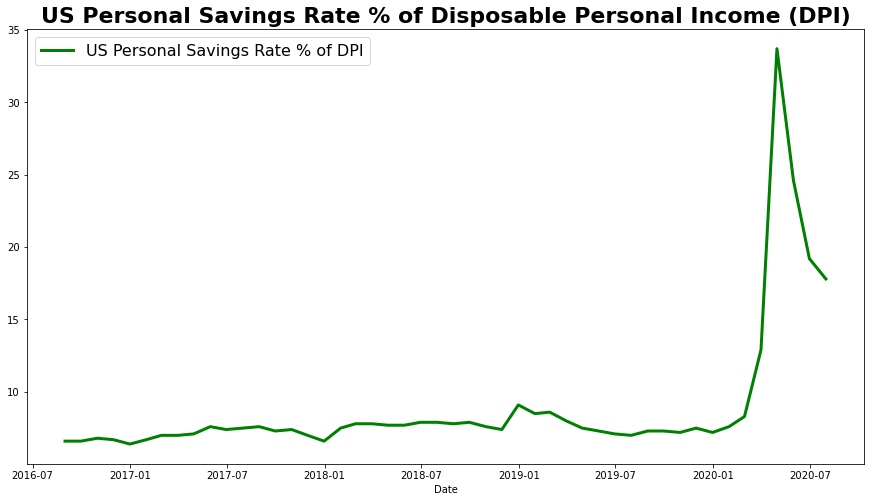

In [83]:
# Chart US_Personal_Savings_Rate_%_of_DPI
x = master_factor_df.index
y = master_factor_df["US_Personal_Savings_Rate_%_of_DPI"]
plt.subplots(figsize=(15,8))
plt.plot(x,y, label="US Personal Savings Rate % of DPI", linewidth=3, color="#008000")

plt.legend(prop={'size': 16})
plt.xlabel("Date")
plt.title(f"US Personal Savings Rate % of Disposable Personal Income (DPI)", fontdict={'fontweight':'bold', 'fontsize':'22'})
plt.savefig(f'Images/Macro_Screen/US_Personal_Savings_Rate_%_of_DPI.png', bbox_inches="tight")
plt.show()

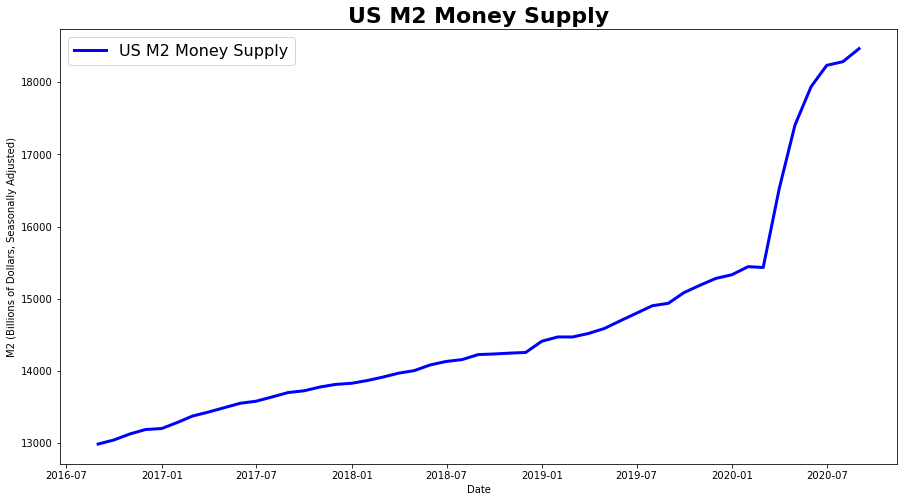

In [84]:
# Chart US M2 Money Supply
x = master_factor_df.index
y = master_factor_df["M2"]
plt.subplots(figsize=(15,8))
plt.plot(x,y, label="US M2 Money Supply", linewidth=3, color="blue")

plt.legend(prop={'size': 16})
plt.xlabel("Date")
plt.ylabel("M2 (Billions of Dollars, Seasonally Adjusted)")
plt.title(f"US M2 Money Supply", fontdict={'fontweight':'bold', 'fontsize':'22'})
plt.savefig(f'Images/Macro_Screen/US M2 Money Supply.png', bbox_inches="tight")
plt.show()

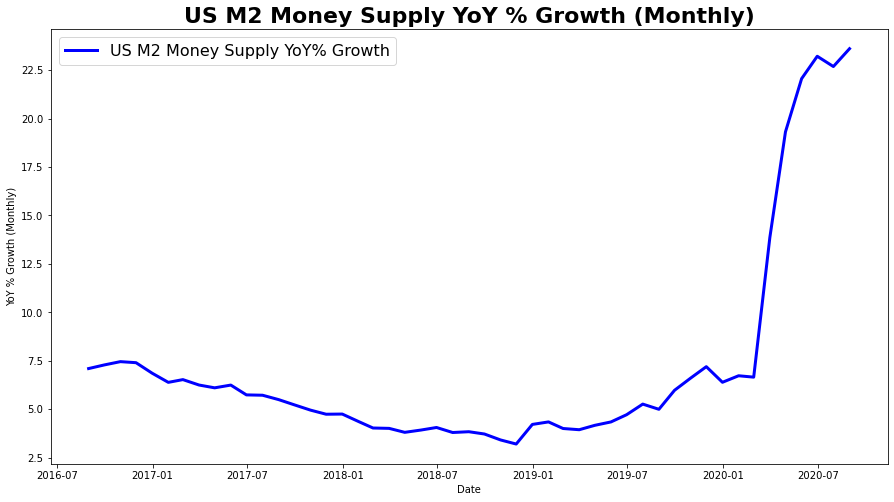

In [85]:
# Chart US M2 Money Supply YoY
x = master_YoY_df.index
y = master_YoY_df["M2_Money_Supply_YoY"]
plt.subplots(figsize=(15,8))
plt.plot(x,y, label="US M2 Money Supply YoY% Growth", linewidth=3, color="blue")

plt.legend(prop={'size': 16})
plt.xlabel("Date")
plt.ylabel("YoY % Growth (Monthly)")
plt.title(f"US M2 Money Supply YoY % Growth (Monthly)", fontdict={'fontweight':'bold', 'fontsize':'22'})
plt.savefig(f'Images/Macro_Screen/US_M2_Money_Supply_YoY.png', bbox_inches="tight")
plt.show()

In [86]:
# M2 vs. GDP
# Concat GDP and M2 dataframes
GDP_M2_df = pd.concat([US_GDP_df,
                       M2_stock_resampled], axis="columns", join='inner')
GDP_M2_df.tail()

,Real GDP,Real GDP YoY,M2,M2_Money_Supply_YoY
Date,,,,
2019-03-31,19020.599,1.963163,14520.7,3.939787
2019-06-30,19141.744,2.076481,14798.1,4.714898
2019-09-30,19253.959,2.338885,15086.4,5.975077
2019-12-31,19010.848,0.319261,15333.6,6.388027
2020-03-31,17282.188,-9.139623,16533.3,13.860213


In [87]:
GDP_M2_df["M2 % of Real GDP"] = (GDP_M2_df["M2"]/GDP_M2_df["Real GDP"])*100
GDP_M2_df.tail()

,Real GDP,Real GDP YoY,M2,M2_Money_Supply_YoY,M2 % of Real GDP
Date,,,,,
2019-03-31,19020.599,1.963163,14520.7,3.939787,76.341970
2019-06-30,19141.744,2.076481,14798.1,4.714898,77.308003
2019-09-30,19253.959,2.338885,15086.4,5.975077,78.354794
2019-12-31,19010.848,0.319261,15333.6,6.388027,80.657107
2020-03-31,17282.188,-9.139623,16533.3,13.860213,95.666706


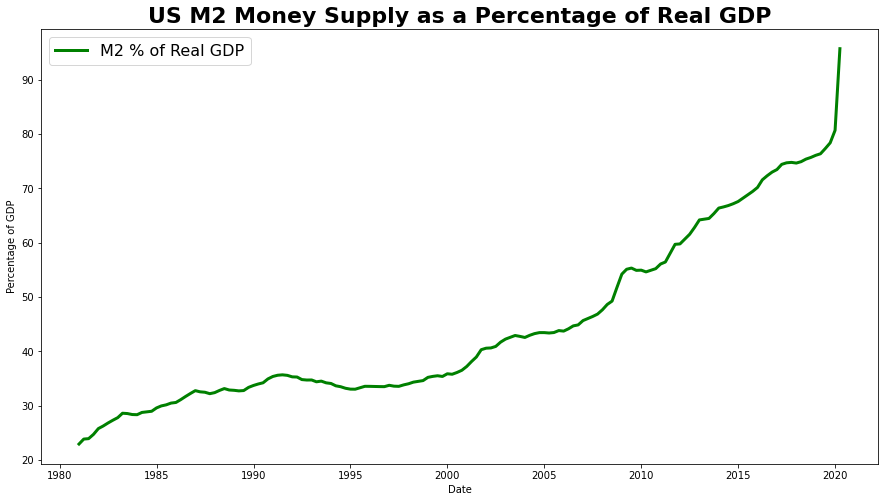

In [88]:
# Plot M2 as a % of Real GDP
# x = master_factor_df.index
# y = master_factor_df["M2"]
plt.subplots(figsize=(15,8))
plt.plot(GDP_M2_df["M2 % of Real GDP"], label="M2 % of Real GDP", linewidth=3, color="#008000")

plt.legend(prop={'size': 16})
plt.xlabel("Date")
plt.ylabel("Percentage of GDP")
plt.title(f"US M2 Money Supply as a Percentage of Real GDP", fontdict={'fontweight':'bold', 'fontsize':'22'})
plt.savefig(f'Images/Macro_Screen/M2 % of Real GDP.png', bbox_inches="tight")
plt.show()

## Conditional Formatting Section

In [89]:
#Conditional formatting
# highlight red if negative
def color_negative(number):
    color = 'red' if number < 0 else 'black'
    return f'color: {color}'

# master_df_transposed.style.applymap(color_negative)
Real_PCE_YoY = master_df_transposed.loc[["Real_PCE_YoY"]].style.applymap(color_negative)
Real_PCE_YoY


Date,2019-09-30 00:00:00,2019-10-31 00:00:00,2019-11-30 00:00:00,2019-12-31 00:00:00,2020-01-31 00:00:00,2020-02-29 00:00:00,2020-03-31 00:00:00,2020-04-30 00:00:00,2020-05-31 00:00:00,2020-06-30 00:00:00,2020-07-31 00:00:00,2020-08-31 00:00:00,2020-09-30 00:00:00
Real_PCE_YoY,2.580000,2.300000,2.060000,3.020000,2.690000,2.610000,-4.690000,-16.700000,-9.880000,-5.080000,-3.770000,nan,nan


In [92]:
# master_df_transposed.loc["Real_PCE_YoY"] = Real_PCE_YoY
master_df_transposed = master_df_transposed_copy
master_df_transposed

Date,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30
Real_PCE,13319.50,13344.30,13356.20,13360.60,13416.70,13402.40,12536.10,10977.00,11904.10,12577.60,12778.20,NaN,NaN
Real_PCE_YoY,2.58,2.30,2.06,3.02,2.69,2.61,-4.69,-16.70,-9.88,-5.08,-3.77,NaN,NaN
Initial_Claims,852000.00,860000.00,1074000.00,904000.00,851000.00,1057000.00,10667000.00,20161000.00,12329000.00,5996000.00,5475000.00,5161000.00,884000.00
Initial_Claims_YoY,-19.85,-0.23,20.81,-17.67,-3.41,17.44,879.52,2238.86,1312.26,442.62,540.35,377.43,3.76
Capacity_Utilization,77.43,76.99,77.57,77.17,76.88,76.93,73.61,64.20,64.78,68.46,70.56,NaN,NaN
Cap_Util_YoY_Change,-2.30,-2.90,-2.51,-2.89,-2.70,-1.95,-6.10,-17.45,-16.73,-11.88,-8.87,NaN,NaN
US_Real_DPI,14933.60,14936.20,14997.20,14960.20,15070.20,15162.60,14949.30,17254.70,16400.80,16107.20,16091.60,NaN,NaN
Real_DPI_YoY,2.02,1.81,2.10,0.83,1.55,2.01,0.63,16.45,10.74,8.64,8.43,NaN,NaN
US_Personal_Savings_Rate_%_of_DPI,7.30,7.20,7.50,7.20,7.60,8.30,12.90,33.70,24.60,19.20,17.80,NaN,NaN
US_Personal_Savings_Rate_%_of_DPI_YoY,-7.59,-5.26,1.35,-20.88,-10.59,-3.49,61.25,349.33,236.99,170.42,154.29,NaN,NaN


In [26]:

master_df_transposed.iloc[1].style.background_gradient(cmap='PuBu', axis=1)

AttributeError: 'Series' object has no attribute 'style'

In [61]:
import seaborn as sns

cm = sns.light_palette("red", as_cmap=True)

master_df_transposed.iloc[:,-10:].style.background_gradient(cmap=cm, axis=1)


Date,2019-10-31 00:00:00,2019-11-30 00:00:00,2019-12-31 00:00:00,2020-01-31 00:00:00,2020-02-29 00:00:00,2020-03-31 00:00:00,2020-04-30 00:00:00,2020-05-31 00:00:00,2020-06-30 00:00:00,2020-07-31 00:00:00
Real_PCE,13344.300000,13356.200000,13360.600000,13416.700000,13402.400000,12536.100000,10977.000000,11904.100000,12577.600000,12778.200000
Real_PCE_YoY,2.300000,2.060000,3.020000,2.690000,2.610000,-4.690000,-16.700000,-9.880000,-5.080000,-3.770000
Initial_Claims,860000.000000,1074000.000000,904000.000000,851000.000000,1057000.000000,10667000.000000,20161000.000000,12329000.000000,5996000.000000,5475000.000000
Initial_Claims_YoY,-0.230000,20.810000,-17.670000,-3.410000,17.440000,879.520000,2238.860000,1312.260000,442.620000,540.350000
Capacity_Utilization,76.990000,77.570000,77.170000,76.880000,76.930000,73.610000,64.200000,64.780000,68.460000,70.560000
Cap_Util_YoY_Change,-2.900000,-2.510000,-2.890000,-2.700000,-1.950000,-6.100000,-17.450000,-16.730000,-11.880000,-8.870000
US_Real_DPI,14936.200000,14997.200000,14960.200000,15070.200000,15162.600000,14949.300000,17254.700000,16400.800000,16107.200000,16091.600000
Real_DPI_YoY,1.810000,2.100000,0.830000,1.550000,2.010000,0.630000,16.450000,10.740000,8.640000,8.430000
US_Personal_Savings_Rate_%_of_DPI,7.200000,7.500000,7.200000,7.600000,8.300000,12.900000,33.700000,24.600000,19.200000,17.800000
US_Personal_Savings_Rate_%_of_DPI_YoY,-5.260000,1.350000,-20.880000,-10.590000,-3.490000,61.250000,349.330000,236.990000,170.420000,154.290000
